# Train and test split + Copying images into train and test folders

## 1. Reload images dataset

In [26]:
import pandas as pd

images_dataset_path = 'data/datasets/images.csv'
df_images = pd.read_csv(images_dataset_path)

display(df_images.columns)
display(df_images.index[:10])

Index(['id_video', 'code', 'folder', 'file_name', 'file_path', 'frame_index',
       'timestamp', 'initial_timestamp', 'seen', 'tags'],
      dtype='object')

RangeIndex(start=0, stop=10, step=1)

## 2. Preprocess the dataset

In [27]:
from modules.octa_video_util import _assign_tag
from modules.octa_video_util import filter_by_query

#### Create categorical field from tag priority list

In [28]:
# Create unique tag column based on class priority list
default_tag = 'normal'
tags_priority_list = ['alagamento', 'bolsão', 'lâmina', 'poça', 'transbordo']

df_images['tag'] = df_images['tags'].apply(lambda tags_list: _assign_tag(tags_list, tags_priority_list, default_tag))
display(df_images.tag.value_counts())

tag
normal        100783
poça           58101
lâmina          5488
alagamento      3150
transbordo      2237
bolsão          1246
Name: count, dtype: int64

#### Drop categories

In [29]:
df_images = df_images[df_images['tag'] != 'transbordo']

#### Binarize categorical variable

In [30]:
target_classes = ['lâmina', 'bolsão', 'alagamento']

# Binarize categorical variable from list of target classes
df_images['flood'] = df_images['tag'].isin(target_classes).astype(int)

display(df_images['flood'].value_counts())
print()
display(df_images.index[:10])

flood
0    158884
1      9884
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

#### Filter images

In [31]:
query_params = {'seen': True}

# Filter dataset of images by query
df_sample = filter_by_query(df_images, query_params).copy()

display(df_sample['flood'].value_counts())
print()
display(df_sample.index[:10])

flood
0    158884
1      9884
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

---
## 4. Shuffling

In [32]:
import numpy as np
import secrets
secrets.randbits(128)

def RNG():
    return np.random.default_rng(122807528840384100672342137672332424406)

# Example usage
# rng = RNG()
# idx = rng.choice(data.index, len(data), replace=replace, shuffle=False)

#### Sampling parameters

In [33]:
target_variable = 'flood'
multiclass_target_variable = 'tag'
groups_variable = 'code'

max_samples = 2000
replace = False
random_state = 0

#### Shuffle Samples

In [34]:
data = df_sample.copy()

data = data.sample(n=len(data), replace=replace, random_state=random_state)

display(data.index[:10])

Index([30512, 25468, 32010, 90272, 77843, 125753, 320, 59674, 49428, 98899], dtype='int64')

#### Get x and y (features and target variable)

In [35]:
# Get x and y
X = data.drop(target_variable, axis=1)
Y = data[target_variable].copy()

Y_multi = data[multiclass_target_variable] 
groups = data[groups_variable].copy()

display(Y.value_counts())
print()
display(Y_multi.value_counts())


flood
0    158884
1      9884
Name: count, dtype: int64

tag
normal        100783
poça           58101
lâmina          5488
alagamento      3150
bolsão          1246
Name: count, dtype: int64

---
## Undersampling separately for minority and majority classes

<strong>Obs: Choose one of the following three options</strong>

##### Optional · Under sampling between subclasses of the majority class only

Best result

In [101]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_multi_res = rus.fit_resample(X[Y==0], Y_multi[Y==0])
x_res = pd.concat([x_res, X[Y==1]])
y_multi_res = pd.concat([y_multi_res, Y_multi[Y==1]])
y_res = Y.loc[y_multi_res.index]

display(y_multi_res.value_counts())
print()
display(y_res.value_counts())
print()
display(y_res.index)

tag
normal        58101
poça          58101
lâmina         5488
alagamento     3150
bolsão         1246
Name: count, dtype: int64

flood
0    116202
1      9884
Name: count, dtype: int64

Index([166353,  37064, 129160,  98792,  93485, 108443,  92090,  82884,  78943,
       111312,
       ...
        52513,  79224,  15115, 150295, 121561,  89231,  49866,  41504,  70608,
       150550],
      dtype='int64', length=126086)

##### Optional · Under sampling between subclasses of the minority class only

In [21]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_multi_res = rus.fit_resample(X[Y==1], Y_multi[Y==1])
x_res = pd.concat([x_res, X[Y==0]])
y_multi_res = pd.concat([y_multi_res, Y_multi[Y==0]])
y_res = Y.loc[y_multi_res.index]

display(y_multi_res.value_counts())
print()
display(y_res.value_counts())
print()
display(y_res.index)

tag
normal        100783
poça           58101
alagamento      1246
bolsão          1246
lâmina          1246
Name: count, dtype: int64

flood
0    158884
1      3738
Name: count, dtype: int64

Index([  3575,  49055,  70597,  29505, 150562,  39867,  12182,  72705,  47044,
       150337,
       ...
        48600, 112555,  86293, 122714,  41993,  97729,  96029, 152810, 118087,
        43567],
      dtype='int64', length=162622)

##### Optional · Under sampling between subclasses of the minority/majority classes separately

In [44]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_multi_res = rus.fit_resample(X[Y==1], Y_multi[Y==1])
x_res_majority, y_res_majority = rus.fit_resample(X[Y==0], Y_multi[Y==0])
x_res = pd.concat([x_res, x_res_majority])
y_multi_res = pd.concat([y_multi_res, y_res_majority])
y_res = Y.loc[y_multi_res.index]

display(y_multi_res.value_counts())
print()
display(y_res.value_counts())
print()
display(y_res.index)

tag
normal        58101
poça          58101
alagamento     1246
bolsão         1246
lâmina         1246
Name: count, dtype: int64

flood
0    116202
1      3738
Name: count, dtype: int64

Index([  3575,  49055,  70597,  29505, 150562,  39867,  12182,  72705,  47044,
       150337,
       ...
       108639, 133793,  73135, 133168, 138218, 108766,  52620, 112555, 122714,
        41993],
      dtype='int64', length=119940)

---
## Undersampling binary classes

In [102]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_res = rus.fit_resample(x_res, y_res)

groups_res = groups.loc[y_res.index].copy()
y_multi_res = Y_multi.loc[y_res.index].copy()

print('Total samples:', len(y_res))
print()
display(y_res.value_counts())
print()
print(y_multi_res.value_counts())
print()
display(y_res.index)

Total samples: 19768



flood
0    9884
1    9884
Name: count, dtype: int64


tag
lâmina        5488
poça          4956
normal        4928
alagamento    3150
bolsão        1246
Name: count, dtype: int64



Index([132442,  73812,  95280,  35296,  73243, 143576, 126209, 148940,  54517,
       113061,
       ...
        52513,  79224,  15115, 150295, 121561,  89231,  49866,  41504,  70608,
       150550],
      dtype='int64', length=19768)

#### Optional · Sampling based on `max_samples`

In [103]:
y_res = pd.concat([
    y_res[y_res == 0].sample(int(max_samples / 2), replace=replace, random_state=random_state),
    y_res[y_res == 1].sample(int(max_samples / 2), replace=replace, random_state=random_state)
], axis=0)

x_res = X.loc[y_res.index].copy()
groups_res = groups.loc[y_res.index].copy()

display(y_res.value_counts())
print()
display(y_res.index)

flood
0    1000
1    1000
Name: count, dtype: int64

Index([151149,  55823,  14423,  70564,  92916, 166171, 111526, 101842, 107063,
       119478,
       ...
       159845, 113351,  50924, 117329,  43412,  21266,  98026, 104296,  29494,
       145661],
      dtype='int64', length=2000)

---
### Even Group Undersample

In [11]:
import numpy as np

def group_even_undersample(x, y, groups, prct=0.5, n=None, random_state=None):
    group_cnt = groups.value_counts()
    if n is None:
        n = int(np.percentile(group_cnt, prct * 100))
    index = []
    for group in group_cnt.index:
        index += y[groups == group].sample(min(n, group_cnt[group]), replace=False, random_state=random_state).index.tolist()
    return x.loc[index], y.loc[index]

#### Undersample single class evenly · keeping all positive samples

In [15]:
subsample_index = []

class_df = df_sample[df_sample['tag'] == 'poça']
x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']

x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=54, random_state=random_state)
subsample_index += y_cls_res.index.tolist()

class_df = df_sample[df_sample['tag'] == 'normal']
x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']

x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=37, random_state=random_state)
subsample_index += y_cls_res.index.tolist()

majority_samples = df_sample.loc[subsample_index]
sample_even = pd.concat([majority_samples, df_sample[df_sample['flood'] == 1.0]])

display(sample_even['flood'].value_counts())
print()
display(sample_even['tag'].value_counts())
print()
display(sample_even.index)

flood
0    10006
1     9884
Name: count, dtype: int64

tag
lâmina        5488
normal        5035
poça          4971
alagamento    3150
bolsão        1246
Name: count, dtype: int64

Index([102541,  88264,  82975,  95097,  75101, 102549, 140199,  69780,  75044,
        85658,
       ...
       166947, 166948, 166949, 166950, 166951, 166952, 166953, 166954, 166955,
       166956],
      dtype='int64', length=19890)

#### One more time · Account for `max_samples`

In [16]:
subsample_index = []

class_df = sample_even[sample_even['flood'] == 0.0]
x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']

x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=6, random_state=random_state)
subsample_index += y_cls_res.index.tolist()

class_df = sample_even[sample_even['flood'] == 1.0]
x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']

x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=34, random_state=random_state)
subsample_index += y_cls_res.index.tolist()

subsample_even = sample_even.loc[subsample_index]

print()
display(subsample_even['flood'].value_counts())
print()
display(subsample_even['tag'].value_counts())
print()
display(subsample_even.index)

flood
1    1083
0    1080
Name: count, dtype: int64

tag
normal        574
lâmina        550
poça          506
alagamento    297
bolsão        236
Name: count, dtype: int64

Index([ 82975, 146294, 131062,  82936,  64347, 130879, 160753, 166698, 163073,
       156635,
       ...
       159950, 159961, 159957, 159949, 159955, 159958, 159951, 159948, 159953,
       159960],
      dtype='int64', length=2163)

#### Final distribution of samples per camera

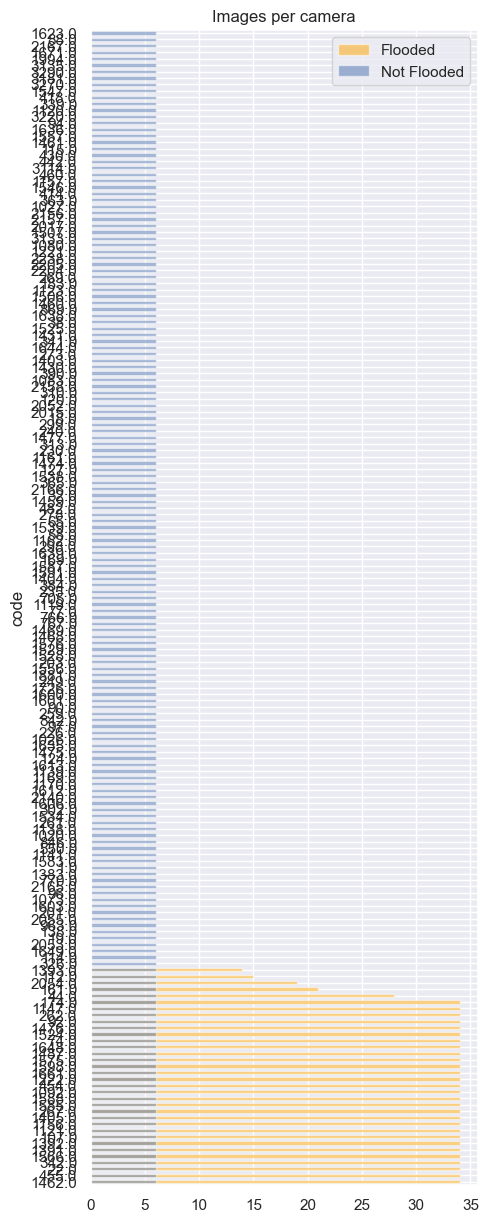

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

fig = plt.figure(figsize=(5, 15))
ax = subsample_even[subsample_even['flood'] == 1.0]['code'].value_counts().plot.barh(label='Flooded', color='orange', alpha=0.5)
subsample_even[subsample_even['flood'] == 0.0]['code'].value_counts().plot.barh(label='Not Flooded', alpha=0.5, ax=ax)

# majority = subsample_even[subsample_even['flood'] == 0.0]
# majority[majority['tag'] == 'poça']['code'].value_counts().plot.barh(label='Not Flooded (Pud)', color='green', alpha=0.5, ax=ax)
# majority[majority['tag'] == 'normal']['code'].value_counts().plot.barh(label='Not Flooded (Normal)', alpha=0.5, ax=ax)

plt.title('Images per camera')
plt.legend()
plt.show()

#### Final undersample variables

In [20]:
x_res = subsample_even.drop('flood', axis=1)
y_res = subsample_even['flood'].copy()
groups_res = subsample_even['code'].copy()

---
### Undersample per camera

In [37]:
code_cnt = groups.value_counts()

code_cnt

code
1462.0    5604
278.0     5397
1461.0    5383
1639.0    5158
1638.0    4455
          ... 
1139.0      17
1169.0      17
1613.0      16
124.0       14
1623.0       8
Name: count, Length: 182, dtype: int64

In [39]:
codes_1 = groups[Y == 1].unique()

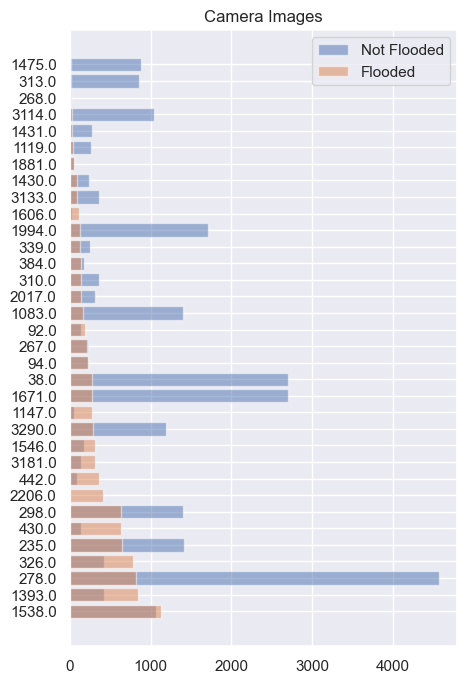

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 8))

cnt_0 = df_sample[df_sample['flood'] == 0]['code'].value_counts()
cnt_1 = df_sample[df_sample['flood'] == 1]['code'].value_counts()

for idx in cnt_1.index:
    if idx not in cnt_0.index:
        cnt_0[idx] = 0
        
cnt_0 = cnt_0.loc[cnt_1.index]

# Plot bars with transparency
plt.barh(cnt_0.index.astype(str), cnt_0.values, alpha=0.5, label='Not Flooded')  # Set transparency to 0.5
plt.barh(cnt_1.index.astype(str), cnt_1.values, alpha=0.5, label='Flooded')  # Set transparency to 0.5

plt.title('Camera Images')
plt.legend()  # Show legend
# plt.ylim(-2, len(cnt_0) + 1)

plt.show()


---
## 5. Train and Test Splitting

#### Optional · Train test split

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_res, y_res, test_size=0.3, shuffle=True, stratify=y_res, random_state=random_state)
train_index, test_index = Y_train.index, Y_test.index

####  Optional · Stratified group KFold split

Obs: Best split result

In [21]:
from sklearn.model_selection import StratifiedGroupKFold

# Stratified group KFold testing  split
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=False, random_state=None)
for i, (train_index, test_index) in enumerate(sgkf.split(x_res, y_res, groups_res)):
    # Get first split folder
    break

X_train = x_res.iloc[train_index]
Y_train = y_res.iloc[train_index]
groups_train = groups_res.iloc[train_index]

X_test = x_res.iloc[test_index]
Y_test = y_res.iloc[test_index]
groups_test = groups_res.iloc[test_index]

# Stratified group KFold validation split
sgkf = StratifiedGroupKFold(n_splits=9, shuffle=False, random_state=None)
for i, (train_index, val_index) in enumerate(sgkf.split(X_train, Y_train, groups_train)):
    break

X_val = X_train.iloc[val_index]
Y_val = Y_train.iloc[val_index]
groups_val = groups_train.iloc[val_index]

X_train = X_train.iloc[train_index]
Y_train = Y_train.iloc[train_index]
groups_train = groups_train.iloc[train_index]

print('Train index:', Y_train.index[:10])
print('Test index:', Y_test.index[:10])
print('Val index:', Y_val.index[:10])

Train index: Index([82975, 146294, 131062, 82936, 64347, 130879, 97626, 139584, 123621,
       123611],
      dtype='int64')
Test index: Index([160753, 166698, 163073, 156635, 158574, 153350, 80639, 94014, 93975,
       120072],
      dtype='int64')
Val index: Index([157109, 166226, 166234, 154007, 158207, 160157, 103914, 103945, 117762,
       117779],
      dtype='int64')


#### Optional · Group shuffle split

In [56]:
# NOTE: This split is not deterministic even using random_state!=None
# NOTE: This split is not stratified
from sklearn.model_selection import GroupShuffleSplit

# Group shuffle split
gss = GroupShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2)

# Get first split folder
for i, (train_index, test_index) in enumerate(gss.split(x_res, y_res, groups_res)):
    break

X_train = x_res.iloc[train_index]
X_test = x_res.iloc[test_index]

Y_train = y_res.iloc[train_index]
Y_test = y_res.iloc[test_index]

#### Report group count and train and test samples for each class (Missing reporting per group class)

In [22]:
def group_split_report(y_res, groups_res, Y_train, Y_test, Y_val):

    train_prct = len(Y_train) / len(y_res)
    test_prct = len(Y_test) / len(y_res)
    val_prct = len(Y_val) / len(y_res)
    groups_train = groups_res.loc[Y_train.index].unique()
    groups_test = groups_res.loc[Y_test.index].unique()
    groups_val = groups_res.loc[Y_val.index].unique()
    class_count = y_res.value_counts()
    train_class_count = Y_train.value_counts()
    test_class_count = Y_test.value_counts()
    val_class_count = Y_val.value_counts()
    train_class_prct = [train_class_count[0] / class_count[0], train_class_count[1] / class_count[1]]
    test_class_prct = [test_class_count[0] / class_count[0], test_class_count[1] / class_count[1]]
    val_class_prct = [val_class_count[0] / class_count[0], val_class_count[1] / class_count[1]]
    train_class_ratio = round(Y_train.value_counts(normalize=True).loc[0] * 100, 2)
    test_class_ratio = round(Y_test.value_counts(normalize=True).loc[0] * 100, 2)
    val_class_ratio = round(Y_val.value_counts(normalize=True).loc[0] * 100, 2)
    
    print('Groups intersecting train and test sets:', len(set(groups_train).intersection(groups_test)))
    print('Groups intersecting train and val sets:', len(set(groups_train).intersection(groups_val)))
    print('Groups intersecting test and val sets:', len(set(groups_test).intersection(groups_val)))
    print()
    
    stats = pd.DataFrame(
        [[len(groups_train), len(groups_test), len(groups_val)],
        [len(Y_train), len(Y_test), len(Y_val)],
        [round(train_prct * 100, 2), round(test_prct * 100, 2), round(val_prct * 100, 2)],
        [train_class_count[0], test_class_count[0], val_class_count[0]],
        [train_class_count[1], test_class_count[1], val_class_count[1]],
        [round(train_class_prct[0] * 100, 2), round(test_class_prct[0] * 100, 2), round(val_class_prct[0] * 100, 2)],
        [round(train_class_prct[1] * 100, 2), round(test_class_prct[1] * 100, 2), round(val_class_prct[1] * 100, 2)],
        [train_class_ratio, test_class_ratio, val_class_ratio]],
        columns=['train', 'test', 'val'], index=['groups', 'total', 'total (%)', '0', '1', '0 (%)', '1 (%)', 'class ratio (%)']
    ).T

    return stats


# Example usage

print('Total samples:', len(y_res))
stats = group_split_report(y_res, groups_res, Y_train, Y_test, Y_val)
display(stats)

Total samples: 2163
Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,145.0,1707.0,78.92,864.0,843.0,80.0,77.84,50.62
test,19.0,231.0,10.68,108.0,123.0,10.0,11.36,46.75
val,18.0,225.0,10.40,108.0,117.0,10.0,10.80,48.00


---
## 6. Copy images into train and test folders

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [23]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/sgkf-8-1-1'
# dataset = data.copy()
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'
train_indexes = list(Y_train.index)
test_indexes = list(Y_test.index)
val_indexes = list(Y_val.index)

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_indexes, test_indexes, val_indexes,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 1707/1707 files (100.00%) - Found: 1707/1707
Copying images to test folders:
Processed 231/231 files (100.00%) - Found: 231/231
Copying images to val folders:


#### Save dataframe of sample images

In [24]:
target_directory = 'data/splits/sgkf-8-1-1'

data_train = data.loc[Y_train.index]
data_test = data.loc[Y_test.index]
data_val = data.loc[Y_val.index]

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (2163, 13)


#### Count save images

In [25]:
import os

target_directory = 'data/splits/sgkf-8-1-1'

print('train:', len(os.listdir(f'{target_directory}/train/0')), len(os.listdir(f'{target_directory}/train/1')))
print('test:', len(os.listdir(f'{target_directory}/test/0')), len(os.listdir(f'{target_directory}/test/1')))
print('val:', len(os.listdir(f'{target_directory}/val/0')), len(os.listdir(f'{target_directory}/val/1')))

train: 863 843
test: 108 123
val: 108 117
